In [70]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBRFRegressor
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from prettytable import PrettyTable

In [71]:
missing_df = pd.read_csv('missingmarks_clean_data.csv')

In [72]:
missing_df.head()

,institution,system,data_loss_gen,data_loss_human,data_loss_machine,data_loss_hybrid,system_error_chance,feature
0,10602,1,2,3,4,1,1,2
1,10612,1,2,3,3,1,1,2
2,10597,1,2,1,1,2,1,1
3,10597,2,2,2,4,2,1,2
4,10597,1,1,1,2,1,1,1


In [73]:
missing_df.isnull().values.any()

False

In [74]:
missing_df.isnull().sum().sum()

0

In [75]:
missing_df.dtypes

institution            int64
system                 int64
data_loss_gen          int64
data_loss_human        int64
data_loss_machine      int64
data_loss_hybrid       int64
system_error_chance    int64
feature                int64
dtype: object

In [76]:
train_cols = ['data_loss_gen', 'data_loss_human', 'data_loss_machine', 'data_loss_hybrid', 'system_error_chance']
x = missing_df[train_cols]
y = missing_df['feature']

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=25)

In [78]:
scaler = StandardScaler()

X_train_scale = scaler.fit_transform(x_train)
X_test_scale = scaler.fit_transform(x_test)

In [79]:
from sklearn.svm import SVC
import numpy as np

In [141]:
def auto_train (x,y, model_alg):
    if model_alg == 'lr':
        model = LinearRegression()
    elif model_alg == 'sv':
        model = SVC(kernel= 'linear', C=1, random_state=1)
    elif model_alg == 'xgb':
        model = XGBRFRegressor()
    elif model_alg == 'rfr':
        model = RandomForestRegressor()
    elif model_alg == 'rfc':
        model = RandomForestClassifier()
        
    model.fit(X_train_scale, np.log(y))
    
    return model

In [81]:
def auto_evaluate(model, x, y):
    predictions = model.predict(x)
    predictions = np.exp(predictions)
    
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions)
    
    mse = round(mse, 2)
    mae = round(mae, 2)
    mape = round(mape, 2)
    
    return [mse, mae, mape]

In [143]:
linear = auto_train(X_train_scale, y_train, 'lr')
#svm = auto_train(X_train_scale, y_train, 'sv')
xgboost = auto_train(X_train_scale, y_train, 'xgb')
random_forest_reg = auto_train(X_train_scale, y_train, 'rfr')
#random_forest_cls = auto_train(X_train_scale, y_train, 'rfc')

In [89]:
linear_evaluate = auto_evaluate(linear, X_test_scale, y_test)
linear_evaluate

[0.04, 0.11, 0.08]

In [90]:
xg_evaluate = auto_evaluate(xgboost, X_test_scale, y_test)
xg_evaluate

[0.02, 0.04, 0.03]

In [91]:
forest_evalaute = auto_evaluate(random_forest_reg, X_test_scale, y_test)
forest_evalaute

[0.02, 0.04, 0.03]

In [92]:
dl_min = Sequential()

dl_min.add(Dense(16, input_dim=X_train_scale.shape[1], activation='relu'))
dl_min.add(Dense(8, activation='relu'))
dl_min.add(Dense(4, activation='relu'))
dl_min.add(Dense(1, activation='linear'))

dl_min.compile(loss='mean_squared_error', optimizer='adam')
dl_min.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [93]:
epochs = 20
batch_size = 10

In [106]:
from livelossplot import PlotLossesKeras

dl_min.fit(X_train_scale, np.log(y_train),
validation_data = (X_test_scale, np.log(y_test)),
epochs = epochs,
verbose=0,
batch_size = batch_size)


Epoch 1/20
804/804 [==============================] - 6s 7ms/step - loss: 0.0142 - val_loss: 0.0108
Epoch 2/20
804/804 [==============================] - 5s 6ms/step - loss: 0.0135 - val_loss: 0.0107
Epoch 3/20
804/804 [==============================] - 5s 6ms/step - loss: 0.0135 - val_loss: 0.0103
Epoch 4/20
804/804 [==============================] - 4s 5ms/step - loss: 0.0134 - val_loss: 0.0104
Epoch 5/20
804/804 [==============================] - 4s 4ms/step - loss: 0.0133 - val_loss: 0.0104
Epoch 6/20
804/804 [==============================] - 3s 4ms/step - loss: 0.0133 - val_loss: 0.0104
Epoch 7/20
804/804 [==============================] - 3s 4ms/step - loss: 0.0133 - val_loss: 0.0108
Epoch 8/20
804/804 [==============================] - 3s 3ms/step - loss: 0.0132 - val_loss: 0.0104
Epoch 9/20
804/804 [==============================] - 3s 3ms/step - loss: 0.0133 - val_loss: 0.0103
Epoch 10/20
804/804 [==============================] - 3s 3ms/step - loss: 0.0133 - val_loss: 0.0104

In [107]:
history_df = pd.DataFrame(dl_min.history.history)
history_df.head(10)

,loss,val_loss
0,0.014236,0.010783
1,0.013459,0.010670
2,0.013493,0.010326
3,0.013367,0.010422
4,0.013297,0.010414
5,0.013315,0.010442
6,0.013267,0.010793
7,0.013248,0.010382
8,0.013289,0.010284
9,0.013262,0.010353


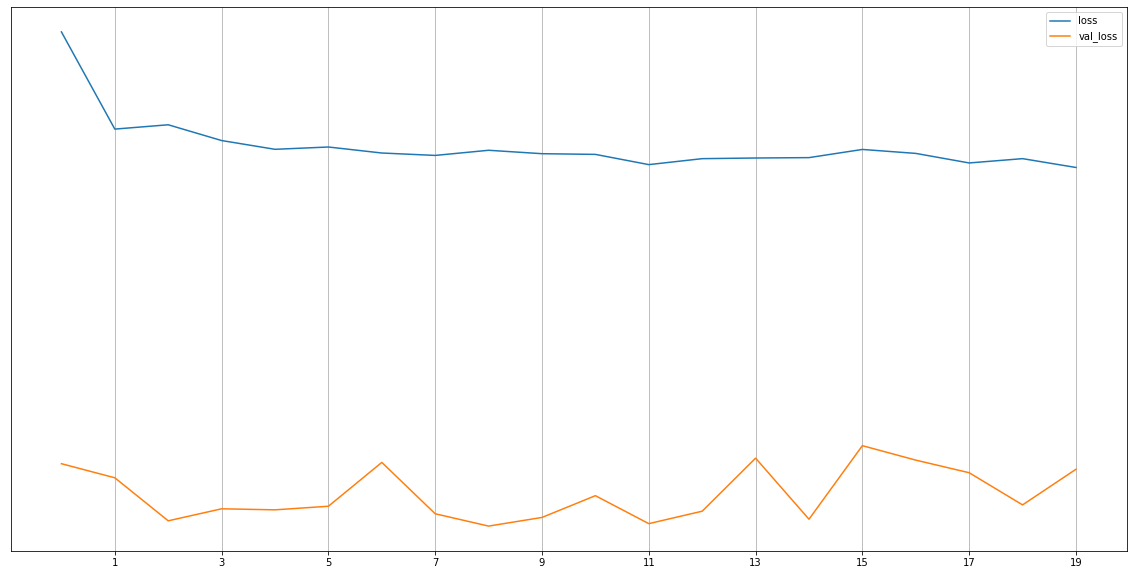

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')
plt.xticks(np.arange(1, epochs+1, 2))
plt.yticks(np.arange(1, max(history_df['loss']), 0.5))
plt.legend()
plt.grid()

In [108]:
dl_min_evaluate = auto_evaluate(dl_min, X_test_scale, y_test)
dl_min_evaluate

[0.02, 0.05, 0.04]

In [109]:
dl_max = Sequential()

dl_max.add(Dense(64, input_dim=X_train_scale.shape[1], activation='relu'))
dl_max.add(Dense(32, activation='relu'))
dl_max.add(Dense(16, activation='relu'))
dl_max.add(Dense(1, activation='linear'))

dl_max.compile(loss='mean_squared_error', optimizer='adam')

dl_max.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


In [121]:
dl_max.fit(X_train_scale, np.log(y_train),
validation_data=(X_test_scale, np.log(y_test)),
epochs= epochs,
batch_size = batch_size)

Epoch 1/20
804/804 [==============================] - 6s 7ms/step - loss: 0.0129 - val_loss: 0.0102
Epoch 2/20
804/804 [==============================] - 4s 5ms/step - loss: 0.0130 - val_loss: 0.0102
Epoch 3/20
804/804 [==============================] - 5s 6ms/step - loss: 0.0130 - val_loss: 0.0102
Epoch 4/20
804/804 [==============================] - 4s 5ms/step - loss: 0.0129 - val_loss: 0.0102
Epoch 5/20
804/804 [==============================] - 3s 4ms/step - loss: 0.0129 - val_loss: 0.0102
Epoch 6/20
804/804 [==============================] - 3s 4ms/step - loss: 0.0130 - val_loss: 0.0103
Epoch 7/20
804/804 [==============================] - 3s 4ms/step - loss: 0.0129 - val_loss: 0.0102
Epoch 8/20
804/804 [==============================] - 4s 4ms/step - loss: 0.0129 - val_loss: 0.0103
Epoch 9/20
804/804 [==============================] - 3s 4ms/step - loss: 0.0129 - val_loss: 0.0104
Epoch 10/20
804/804 [==============================] - 3s 4ms/step - loss: 0.0129 - val_loss: 0.0102

In [122]:
dl_max_evaluate = auto_evaluate(dl_max, X_test_scale, y_test)
dl_max_evaluate

[0.02, 0.05, 0.03]

In [123]:
historymax_df =  pd.DataFrame(dl_max.history.history)
historymax_df.head()

""


In [125]:
summary = PrettyTable(['Model', 'MSE', 'MAE', 'MAPE'])

summary.add_row(['LR'] + auto_evaluate(linear, X_test_scale, y_test))
summary.add_row(['XGB'] + auto_evaluate(xgboost, X_test_scale, y_test))
summary.add_row(['RFR'] + auto_evaluate(random_forest_reg, X_test_scale, y_test))

summary.add_row(['DL_MIN'] + auto_evaluate(dl_min, X_test_scale, y_test))
summary.add_row(['DL_MAX'] + auto_evaluate(dl_max, X_test_scale, y_test))

print(summary)

+--------+------+------+------+
| Model  | MSE  | MAE  | MAPE |
+--------+------+------+------+
|   LR   | 0.04 | 0.11 | 0.08 |
|  XGB   | 0.02 | 0.04 | 0.03 |
|  RFR   | 0.02 | 0.04 | 0.03 |
| DL_MIN | 0.02 | 0.05 | 0.04 |
| DL_MAX | 0.02 | 0.05 | 0.03 |
+--------+------+------+------+


In [136]:
predict_1 = np.exp(linear.predict(X_test_scale))

In [ ]:
predict = np.exp(random_forest_reg.predict(X_test_scale))

In [ ]:
observes = 20

x_ax = range(len(y_test[:observes]))

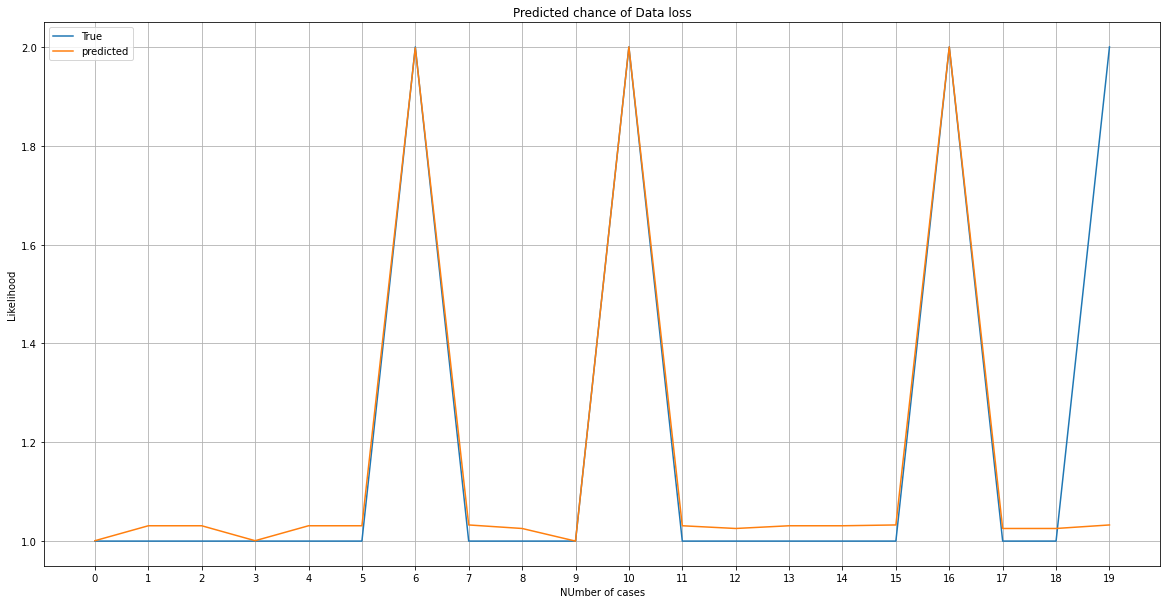

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(x_ax, y_test[:observes], label='True')
plt.plot(x_ax, predict[:observes], label='predicted')
plt.title("Predicted chance of Data loss")
plt.xlabel('NUmber of cases')
plt.ylabel('Likelihood')
plt.xticks(np.arange(observes))
plt.legend()
plt.grid()
plt.show()